In [200]:
from __future__ import division
import numpy as np
import scipy.io as scipy
import matplotlib.pyplot as plt
!pip install mne
import mne
from numpy import *
from numpy.fft import *
import scipy.signal as signal
from matplotlib.pyplot import *

In [201]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], scipy.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, scipy.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [202]:
def sg_plot( t_range, f_range, y, dbf = 60, fig = None) :
    '''
    Plot an image of the spectrogram y, with the axis labeled with time tl,
    and frequency fl
    
    t_range -- time axis label, nt samples
    f_range -- frequency axis label, nf samples
    y -- spectrogram, nf by nt array
    dbf -- Dynamic range of the spectrum
    '''
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
 
    fig=figure(figsize=(16,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    
    return fig

def myspectrogram_hann_ovlp(x, m, fs, fc=0, dbf = 60, fig = None):
    '''
    Plot the spectrogram of x.
    First take the original signal x and split it into blocks of length m
    This corresponds to using a Hanning window
    Inputs: 
            x - data
            m - window size
            fs - sampling rate
    '''
    
    # check if x is real
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x, np.zeros(-lx + nt * m))
    x = x.reshape((m // 2, nt * 2), order='F')
    x = concatenate((x, x), axis=0)
    x = x.reshape((m * nt * 2, 1), order='F')
    x = x[r_[m//2:len(x), np.ones(m // 2) * (len(x) - 1)].astype(int)].reshape((m, nt * 2), order='F')
    
    
    xmw = x * hanning(m)[:, None];
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = fft(xmw, len(xmw), axis=0)
        fig = sg_plot(t_range, f_range, xmf[0:m//2, :], dbf, fig);
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = abs(fftshift(fft(xmw, len(xmw), axis=0), axes=0 ))
        fig = sg_plot(t_range, f_range, xmf, dbf, fig);
    
    return fig

In [203]:
p1 = loadmat('P1/WS_P1_S9.mat')

In [204]:
p1_arr = np.array(p1['ws']['win'][0]['eeg'])
p1_arr_t = np.array(p1['ws']['win'][0]['eeg_t'])

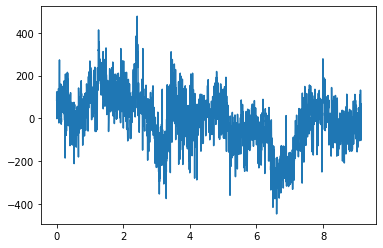

In [205]:
plt.figure()
plt.plot(p1_arr_t, p1_arr[:,0])
plt.show()

In [206]:
#directory of channel locations
ch_pos = {"Fp1": [-2.7, 8.6, 3.6],
          "Fp2": [2.7, 8.6, 3.6],
          "F7": [-6.7, 5.2, 3.6],
          "F3": [-4.7, 6.2, 8],
          "Fz": [0, 6.7, 9.5],
          "F4": [4.7, 6.2, 8],
          "F8": [6.7, 5.2, 3.6],
          "FC5": [-5.5, 3.2, 6.6],
          "FC1": [-3, 3.3, 11],
          "FC2": [3, 3.3, 11],
          "FC6": [5.5, 3.2, 6.6],
          "T7": [-7.8, 0, 3.6],
          "C3": [-6.1, 0, 9.7],
          "Cz": [0, 0, 12],
          "C4": [6.1, 0, 9.7],
          "T8": [7.8, 0, 3.6],
          "TP9": [-7.3, -2.5, 0],
          "CP5": [-7.2, -2.7, 6.6],
          "CP1": [-3, -3.2, 11],
          "CP2": [3, -3.2, 11],
          "CP6": [7.2, -2.7, 6.6],
          "TP10": [7.3, -2.5, 0],
          "P7": [-6.7, -5.2, 3.6],
          "P3": [-4.7, -6.2, 8],
          "Pz": [0, -6.7, 9.5],
          "P4": [4.7, -6.2, 8],
          "P8": [6.7, -5.2, 3.6],
          "PO9": [-4.7, -6.7, 0],
          "O1": [-2.7, -8.6, 3.6],
          "Oz": [0, -9, 3.6],
          "O2": [2.7, -8.6, 3.6],
          "PO10": [4.7, -6.7, 0]}

In [207]:
chan_locs = mne.channels.make_dig_montage(ch_pos)

In [208]:
ch_names = ['Fp1','Fp2','F7','F3','Fz','F4','F8','FC5','FC1','FC2','FC6','T7','C3','Cz','C4','T8','TP9','CP5','CP1','CP2','CP6','TP10','P7','P3','Pz','P4','P8','PO9','O1','Oz','O2','PO10']
s_freq = 500
info = mne.create_info(ch_names, s_freq, ch_types = "eeg")
info = info.set_montage(montage = chan_locs , verbose = None)
samples = np.array(p1['ws']['win'][0]['eeg'])
samples = np.transpose(samples)
print(samples.shape)
raw = mne.io.RawArray(samples, info)  
type(raw)

(32, 4570)
Creating RawArray with float64 data, n_channels=32, n_times=4570
    Range : 0 ... 4569 =      0.000 ...     9.138 secs
Ready.


<ipython-input-208-2bb5abb93a27>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info = info.set_montage(montage = chan_locs , verbose = None)


mne.io.array.array.RawArray

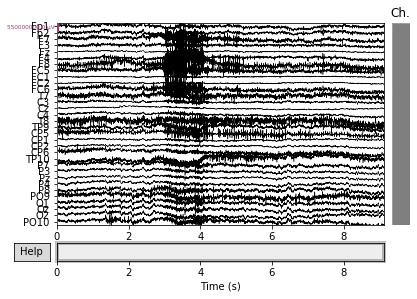

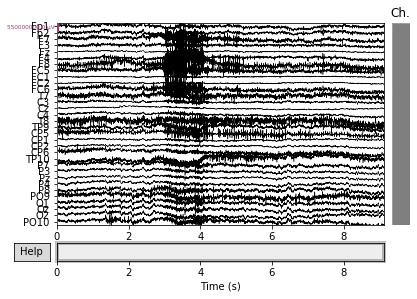

In [209]:
raw.plot(n_channels = 32, scalings = "auto")

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


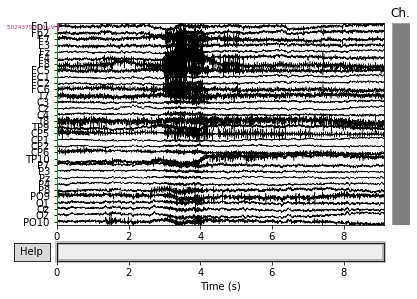

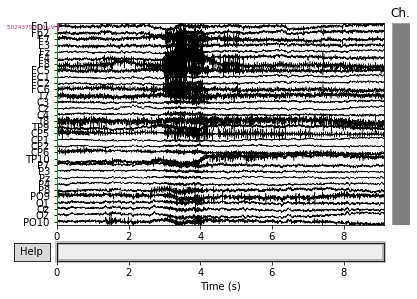

In [210]:
avg_ref = raw.copy().set_eeg_reference(ref_channels='average')
avg_ref.plot(n_channels = 32, scalings = "auto")

In [211]:
'''
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    print(type(data))
    y = signal.sosfilt(sos, data)
    return y
'''

"\nfrom scipy.signal import butter, lfilter\n\ndef butter_bandpass(lowcut, highcut, fs, order=5):\n    nyq = 0.5 * fs\n    low = lowcut / nyq\n    high = highcut / nyq\n    sos = butter(order, [low, high], btype='band', output='sos')\n    return sos\n\n\ndef butter_bandpass_filter(data, lowcut, highcut, fs, order=5):\n    sos = butter_bandpass(lowcut, highcut, fs, order=order)\n    print(type(data))\n    y = signal.sosfilt(sos, data)\n    return y\n"

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



<ipython-input-212-07bf05f87cb3>:1: RuntimeWarning: filter_length (16501) is longer than the signal (4570), distortion is likely. Reduce filter length or filter a longer signal.
  avg_ref_filter = avg_ref.copy().filter(l_freq = 0.1, h_freq = 30)


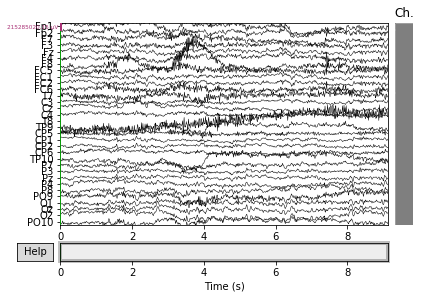

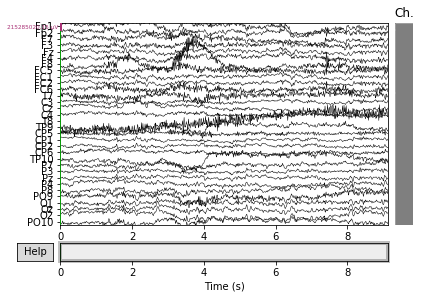

In [212]:
avg_ref_filter = avg_ref.copy().filter(l_freq = 0.1, h_freq = 30)
avg_ref_filter.plot(n_channels = 32, scalings = "auto")

Effective window size : 4.096 (s)


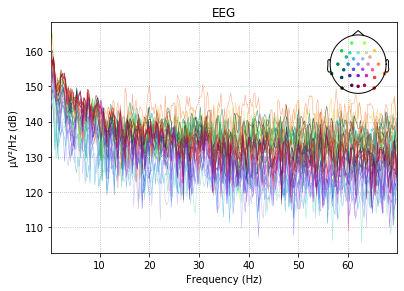

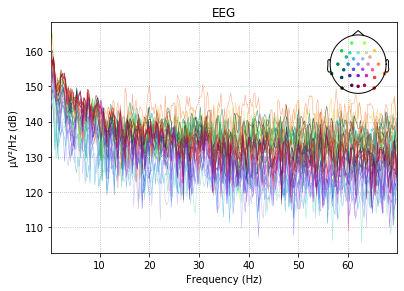

In [213]:
raw.plot_psd(fmin = 0.1, fmax = 70)

Effective window size : 4.096 (s)


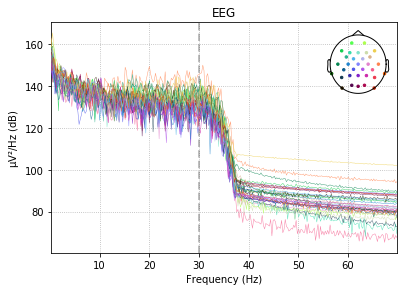

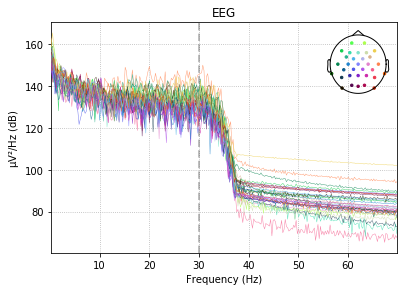

In [214]:
avg_ref_filter.plot_psd(fmin = 0.1, fmax = 70)

In [216]:
ica = mne.preprocessing.ICA(n_components = 32)
pick_channels = ['Fp1',
 'Fp2',
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'FC5',
 'FC1',
 'FC2',
 'FC6',
 'T7',
 'C3',
 'Cz',
 'C4',
 'T8',
 'TP9',
 'CP5',
 'CP1',
 'CP2',
 'CP6',
 'TP10',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'PO9',
 'O1',
 'Oz',
 'O2',
 'PO10']
ica.fit(avg_ref_filter.copy())
ica.get_components()

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 32 components
Fitting ICA took 2.0s.


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


array([[-4.61242470e-04,  4.14694602e-04,  3.84854735e-04, ...,
        -1.26279607e-05,  1.12455407e-05, -8.28054854e-06],
       [-1.39262063e-04,  1.25207954e-04,  1.16198459e-04, ...,
        -3.81273617e-06,  3.39534475e-06, -2.50013029e-06],
       [ 4.85257064e-04, -4.36285682e-04, -4.04892201e-04, ...,
         1.32854356e-05, -1.18310399e-05,  8.71167539e-06],
       ...,
       [ 2.11398778e-03, -1.90064744e-03, -1.76388399e-03, ...,
         5.78770522e-05, -5.15410813e-05,  3.79517923e-05],
       [-1.76315748e-04,  1.58522239e-04,  1.47115574e-04, ...,
        -4.82719714e-06,  4.29874970e-06, -3.16534406e-06],
       [ 8.38192909e-05, -7.53603794e-05, -6.99377293e-05, ...,
         2.29481623e-06, -2.04359596e-06,  1.50478274e-06]])

Transforming to ICA space (32 components)
Zeroing out 0 ICA components


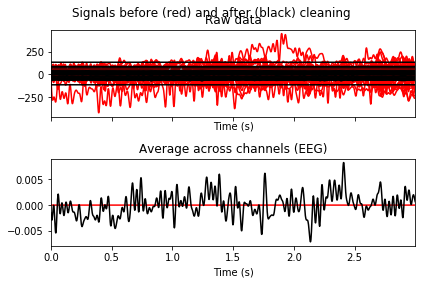

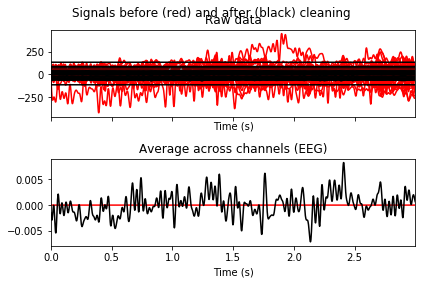

In [217]:
ica.plot_overlay(avg_ref_filter, picks='eeg')


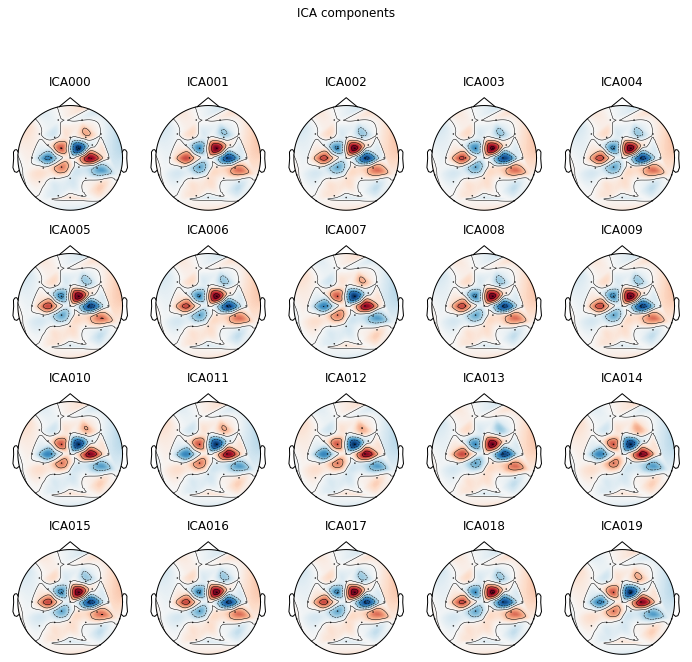

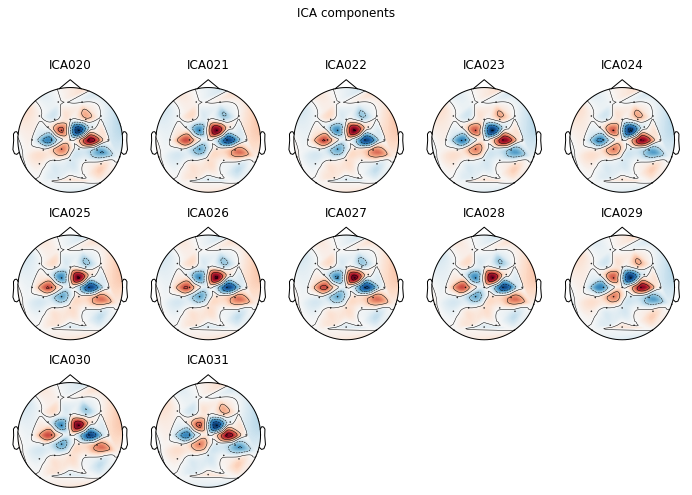

[<Figure size 702x678.24 with 20 Axes>, <Figure size 702x508.68 with 12 Axes>]

In [218]:
ica.plot_components()

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 3.3s.


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


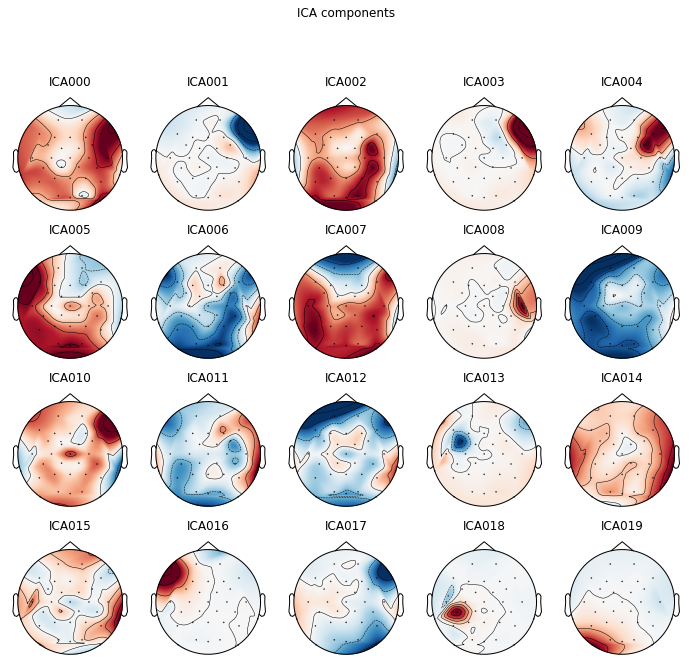

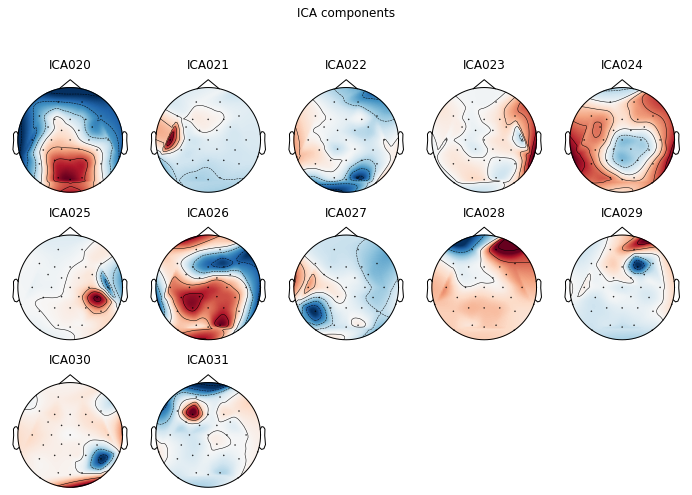

[<Figure size 702x678.24 with 20 Axes>, <Figure size 702x508.68 with 12 Axes>]

In [219]:
ica.fit(raw)
ica.get_components()
ica.plot_components()